In [1]:
# Torch has to go first due to an importing bug
import collections
import logging
import os
import re

import numpy as np
import PIL
import scipy.io
import scipy.ndimage

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests



In [2]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tensorize = transforms.ToTensor()

In [3]:
def denorm(x):
    means = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    stds = torch.FloatTensor([0.225, 0.225, 0.225])[None, :, None, None]
    if x.is_cuda:
        means = means.cuda()
        stds = stds.cuda()
    return x * stds + means

In [4]:
def rescale(img, scale):
    y, x, _ = img.shape
    return cv2.resize(img, (int(x * scale), int(y * scale)), interpolation = cv2.INTER_CUBIC)

In [5]:
def to_np(x):
    return x.detach().cpu().numpy()

In [6]:
def httpimage(url, raw=True):
    img = requests.get(url, stream=True).raw
    return img if raw else np.array(Image.open(img))

## Fetch and wrap VGG network

In [7]:
class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """

    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]

    def forward(self, x):
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2).contiguous()
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        return (x - Variable(means)) / Variable(stds)

In [8]:
class VGG(torch.nn.Module):
    """Wrapper around the VGG network allowing convenient extraction of layer activations.
    """

    FEATURE_LAYER_NAMES = [
        "conv1_1", "relu1_1",
        "conv1_2", "relu1_2",
        "pool1",
        "conv2_1", "relu2_1",
        "conv2_2", "relu2_2",
        "pool2",
        "conv3_1", "relu3_1",
        "conv3_2", "relu3_2",
        "conv3_3", "relu3_3",
        "conv3_4", "relu3_4",
        "pool3",
        "conv4_1", "relu4_1",
        "conv4_2", "relu4_2",
        "conv4_3", "relu4_3",
        "conv4_4", "relu4_4",
        "pool4",
        "conv5_1", "relu5_1",
        "conv5_2", "relu5_2",
        "conv5_3", "relu5_3",
        "conv5_4", "relu5_4",
        "pool5",
    ]

    def __init__(self):
        super(VGG, self).__init__()
        vgg = torchvision.models.vgg19(pretrained=True)
        self.preprocess = VGGPreprocess()
        self.features = vgg.features

        assert len(VGG.FEATURE_LAYER_NAMES) == len(self.features)

    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(VGG.FEATURE_LAYER_NAMES, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError("Layer %s not found" % layer_name)

## Create dreamer

In [9]:
class Dreamer(VGG):
    def __init__(self, layer, auto_cuda = True):
        super(Dreamer, self).__init__()
        cuda = torch.cuda.is_available() and auto_cuda
        self.device = 'cuda' if cuda else 'cpu'
        self.eval()
        self.layer = layer
        self.to(self.device)
        for param in self.parameters():
            param.requires_grad = False

    def dream(self, image, iterations, lr=0.2):
        tim = tensorize(image).to(self.device)
        tim = self.preprocess(tim)

        self.zero_grad()
        tim.requires_grad = True
        for i in range(iterations):
            activations = self.layer_activations(tim, self.layer)
            loss = activations.norm()
            loss.backward()
            tim.data = tim.data + lr * tim.grad.data

        img_out = denorm(tim)
        return to_np(img_out)[0].transpose(1,2,0)

    def lucid_dream(self, img : np.array, steps, iterations = 5, lr = 0.005, scale = 1.5):
        #To visualize features at different scales, the image is resized multiple times and run thru the dream
        y, x, _ = img.shape
        img = cv2.resize(img, (24, 16))

        for n in range(steps):
            img = rescale(img, scale)
            img = self.dream(img, iterations, lr)

        img = cv2.resize(img, (x, y))
        return img

## Deep dream

In [10]:
def dream(url, layer = 'conv5_1', iterations = 10, lucid = True):
    image = httpimage(url, False)
    dreamer = Dreamer(layer)
    method = dreamer.lucid_dream if lucid else dreamer.dream
    plt.imshow(method(image, 10))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


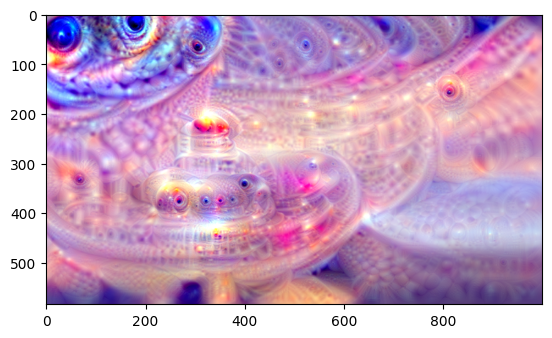

In [11]:
dream('https://s3.amazonaws.com/pbblogassets/uploads/2018/10/22074923/pink-sky-cover.jpg')

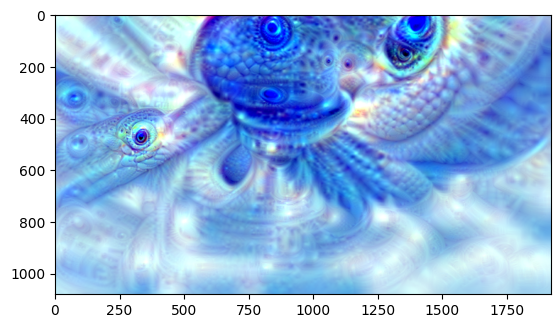

In [13]:
dream('https://www-cdn.eumetsat.int/files/styles/16_9_large/s3/2022-07/cirrus_clouds_aspot_AdobeStock.jpg?h=d1cb525d&itok=EzXtlBkL')